In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [37]:
# 1. Build the Metadata DataFrame
# --------------------------
base_url = "https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor"
# Using Day_1 and devices 1 through 4 in this example; adjust as needed.
days = [f"Day_{i}" for i in range(1, 2)]  
devices = [f"device_{i}" for i in range(1, 5)]  
filename = [f"tx_{i}_iq.dat" for i in range(1, 2)]  


records = []
for day in days:
    for device in devices:
        url = f"{base_url}/{day}/{device}/{filename}"
        records.append({
            "day": day,
            "device": device,
            "filename": filename,
            "url": url
        })

df = pd.DataFrame(records)

df


,day,device,filename,url
0,Day_1,device_1,[tx_1_iq.dat],https://research.engr.oregonstate.edu/hamdaoui...
1,Day_1,device_2,[tx_1_iq.dat],https://research.engr.oregonstate.edu/hamdaoui...
2,Day_1,device_3,[tx_1_iq.dat],https://research.engr.oregonstate.edu/hamdaoui...
3,Day_1,device_4,[tx_1_iq.dat],https://research.engr.oregonstate.edu/hamdaoui...


In [38]:
def fetch_full_IQ_data(url, data_size):

    """
    Fetches the binary file from the URL and converts it to full IQ data.
    
    Parameters:
        url (str): URL to the .dat file.
        data_size (int): Total number of float32 values expected in the file.
        
    Returns:
        complex_data (np.array): Complex-valued array containing the full IQ data.
        I (np.array): Array of the in-phase components.
        Q (np.array): Array of the quadrature components.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Check for HTTP errors
        
        # Read the binary content into a buffer
        file_buffer = BytesIO(response.content)
        
        # Convert the binary content to a NumPy array of type float32.
        vals = np.frombuffer(file_buffer.getvalue(), dtype=np.float32, count=data_size)
        
        # Check if the expected amount of data was read
        if vals.size != data_size:
            print(f"Warning: Expected {data_size} float32 values, but got {vals.size}.")
        
        # Extract I (real) and Q (imaginary) values
        I = vals[0::2]  # Every even-indexed value
        Q = vals[1::2]  # Every odd-indexed value
        
        # Combine into a complex-valued array
        complex_data = I + 1j * Q
        
        return complex_data, I, Q
    except Exception as e:
        print(f"Error fetching or processing {url}: {e}")
        return None, None, None

In [93]:
def fix_signal_length(segments, signal_length=500):
    fixed_segments = []
    for seg in segments:
        if seg.shape[1] < signal_length:
            print(f"Padding segment from {seg.shape[1]} to {signal_length}")  # Debugging
            padded = np.zeros((2, signal_length), dtype=np.float32)
            padded[:, :seg.shape[1]] = seg  # Copy existing values
            fixed_segments.append(padded)
        elif seg.shape[1] > signal_length:
            print(f"Trimming segment from {seg.shape[1]} to {signal_length}")  # Debugging
            fixed_segments.append(seg[:, :signal_length])  # Trim excess
        else:
            fixed_segments.append(seg)  # Already correct
    return np.array(fixed_segments, dtype=np.float32)


In [94]:
# 3. Fetch Data, Segment, and Aggregate Samples
# --------------------------

# Parameters
import numpy as np
from sklearn.model_selection import train_test_split

data_size = 1000000    # Expected total number of float32 values per file (adjust as needed)
signal_length = 500    # Desired segment length for each sample

# Define the list of transmission files you want to process.
tx_files = ['tx_1_iq.dat', 'tx_2_iq.dat', 'tx_3_iq.dat']
# tx_files = ['tx_1_iq.dat']

# Lists to collect all segments and corresponding labels
all_segments = []
all_labels = []

# Create a mapping for devices to numeric labels
device_to_label = {device: idx for idx, device in enumerate(sorted(df['device'].unique()))}

# Loop over each record in the DataFrame
for index, row in df.iterrows():
    day = row['day']
    device = row['device']
    # Base URL pattern for the current day and device.
    base_url = f"https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/{day}/{device}/"
    
    # Process each tx file for this device and day.
    for tx in tx_files:
        url = base_url + tx
        print(f"Processing URL: {url}")
        
        # Fetch and decode the IQ data
        complex_data, I, Q = fetch_full_IQ_data(url, data_size)
        if complex_data is None:
            continue  # Skip files that failed to load
        
        # Calculate the number of complete segments we can extract from this file
        num_samples = len(I) // signal_length
        for i in range(num_samples):
            start = i * signal_length
            end = start + signal_length
            # Extract segments for I and Q components
            segment_I = I[start:end]
            segment_Q = Q[start:end]
            # Stack to create a two-channel sample: shape (2, signal_length)
            segment = np.stack([segment_I, segment_Q], axis=0)
            
            all_segments.append(segment)
            all_labels.append(device_to_label[device])

all_segments = fix_signal_length(all_segments, signal_length=500)  # ✅ Fix segment lengths
all_labels = np.array(all_labels, dtype=np.int64)

print("Fixed data segments shape:", all_segments.shape)  # Debugging
print("Fixed labels shape:", all_labels.shape)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    all_segments, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Now split X_train into train (80%) and validation (20%) within training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Print shapes to verify correctness
print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"X_test.shape: {X_test.shape}")



Processing URL: https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/Day_1/device_1/tx_1_iq.dat
Processing URL: https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/Day_1/device_1/tx_2_iq.dat
Processing URL: https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/Day_1/device_1/tx_3_iq.dat
Processing URL: https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/Day_1/device_2/tx_1_iq.dat
Processing URL: https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/Day_1/device_2/tx_2_iq.dat
Processing URL: https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/Day_1/device_2/tx_3_iq.dat
Processing URL: https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/Day_1/device_3/tx_1_iq.dat
Processing URL: https://research.engr.oregonstate.edu/hamdaoui/RFFP-dataset/WiFi-Dataset/Indoor/Day_1/device_3/tx_2_iq.dat
Processing URL: 

In [95]:
print(f"Final X_val shape BEFORE DataLoader: {X_val.shape}")  # Expected: (1920, 2, 500)


Final X_val shape BEFORE DataLoader: (1920, 2, 500)


In [100]:
# 1. Define a custom Dataset
# --------------------------
class WiFiSignalDataset(Dataset):
    def __init__(self, data, labels):
        """
        data: numpy array of shape (num_samples, channels, signal_length)
        labels: numpy array of shape (num_samples,)
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert data and label to torch tensors
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

# Create Dataset objects and DataLoaders
batch_size = 32
train_dataset = WiFiSignalDataset(X_train, y_train)
test_dataset  = WiFiSignalDataset(X_test, y_test)
validation_dataset = WiFiSignalDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

X_val = X_val[:, :, :500]  # Force reshape if incorrect
print(X_val.shape[2])

print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"X_test.shape: {X_test.shape}")

# Ensure all segments are exactly signal_length=500
def fix_signal_length(data, signal_length):
    fixed_data = np.zeros((data.shape[0], 2, signal_length), dtype=np.float32)
    for i in range(data.shape[0]):
        length = min(data.shape[2], signal_length)
        fixed_data[i, :, :length] = data[i, :, :length]  # Pad or truncate
    return fixed_data

# Ensure all segments are exactly signal_length=500 BEFORE creating DataLoaders
X_train = fix_signal_length(X_train, 500)
X_val = fix_signal_length(X_val, 500)
X_test = fix_signal_length(X_test, 500)

# ✅ Debugging
print(f"Fixed X_train.shape: {X_train.shape}")  # Should be (7680, 2, 500)
print(f"Fixed X_val.shape: {X_val.shape}")  # Should be (1920, 2, 500)
print(f"Fixed X_test.shape: {X_test.shape}")  # Should be (2400, 2, 500)

# Now create dataset objects
train_dataset = WiFiSignalDataset(X_train, y_train)
test_dataset = WiFiSignalDataset(X_test, y_test)
validation_dataset = WiFiSignalDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




500
X_train.shape: (7680, 2, 500)
X_val.shape: (1920, 2, 500)
X_test.shape: (2400, 2, 500)
Fixed X_train.shape: (7680, 2, 500)
Fixed X_val.shape: (1920, 2, 500)
Fixed X_test.shape: (2400, 2, 500)


In [103]:


# 2. Define a Model Architecture
# --------------------------
class DeviceClassifier(nn.Module):
    def __init__(self, num_classes, signal_length):
        super(DeviceClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, padding=1),  # Accept 2 channels
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        # 🔴 Compute conv_output_size dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, 2, signal_length)  # Shape: (batch=1, channels=2, signal_length)
            conv_out = self.features(dummy_input)
            conv_output_size = conv_out.shape[-1]  # Correct size after Conv1D layers

        print(f"✅ Corrected conv_output_size: {conv_output_size}")  # Debugging

        # 🔴 Now define the classifier correctly
        self.classifier = nn.Sequential(
            nn.Linear(4000, 128),  # ✅ Fix: Change input size from 800 to 4000
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x


# And then instantiate the model as before:
signal_length = 100
num_classes = 5  # or your desired number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeviceClassifier(num_classes, signal_length).to(device)

✅ Corrected conv_output_size: 25


In [108]:
# 4. Setup Loss and Optimizer
# Setup Loss Function and Optimizer
# ---------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Configuration
# ----------------------
# Lists to store accuracy and loss values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

num_epochs = 56 

# Training Loop
# -------------
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Accumulate loss and accuracy
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate validation loss and accuracy
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "device_classifier.pth")


Epoch [1/56] | Train Loss: 0.0693, Train Acc: 0.9745 | Val Loss: 0.2799, Val Acc: 0.9255
Epoch [2/56] | Train Loss: 0.0698, Train Acc: 0.9747 | Val Loss: 0.2216, Val Acc: 0.9370
Epoch [3/56] | Train Loss: 0.0694, Train Acc: 0.9766 | Val Loss: 0.2050, Val Acc: 0.9286
Epoch [4/56] | Train Loss: 0.0687, Train Acc: 0.9764 | Val Loss: 0.1976, Val Acc: 0.9370
Epoch [5/56] | Train Loss: 0.0555, Train Acc: 0.9799 | Val Loss: 0.1802, Val Acc: 0.9453
Epoch [6/56] | Train Loss: 0.0581, Train Acc: 0.9790 | Val Loss: 0.2862, Val Acc: 0.9156
Epoch [7/56] | Train Loss: 0.0747, Train Acc: 0.9717 | Val Loss: 0.2068, Val Acc: 0.9328
Epoch [8/56] | Train Loss: 0.0539, Train Acc: 0.9818 | Val Loss: 0.2141, Val Acc: 0.9417
Epoch [9/56] | Train Loss: 0.0602, Train Acc: 0.9788 | Val Loss: 0.2293, Val Acc: 0.9411
Epoch [10/56] | Train Loss: 0.0545, Train Acc: 0.9801 | Val Loss: 0.2519, Val Acc: 0.9297
Epoch [11/56] | Train Loss: 0.0527, Train Acc: 0.9827 | Val Loss: 0.2258, Val Acc: 0.9422
Epoch [12/56] | Tra

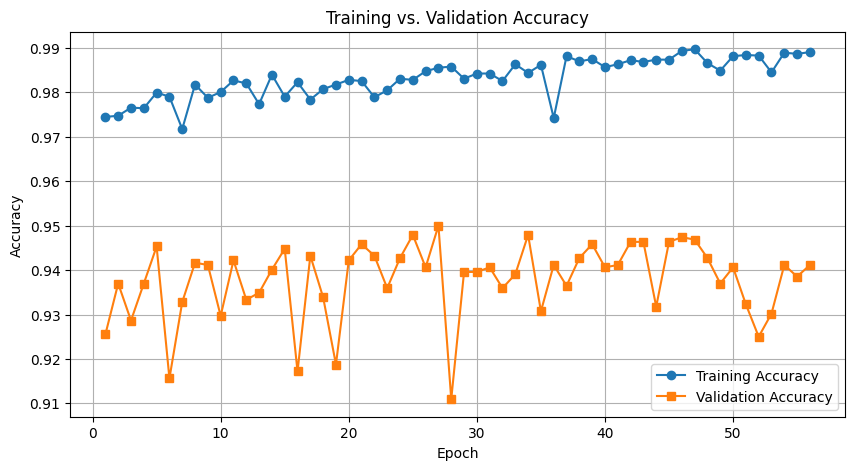

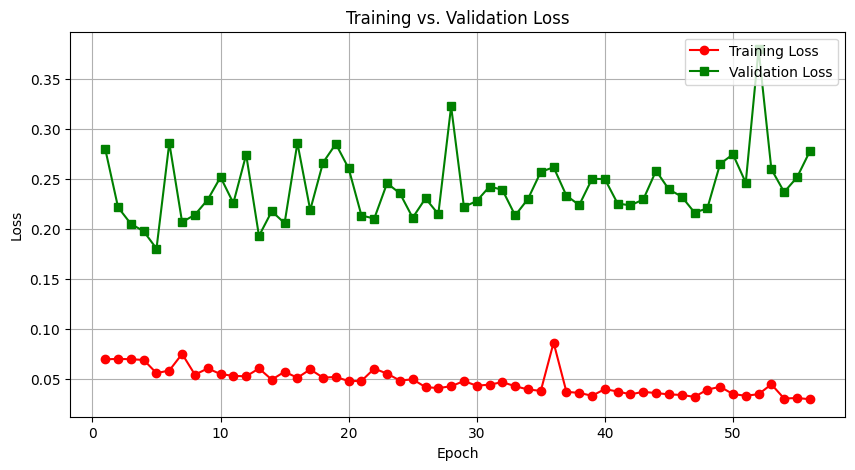

In [114]:
import matplotlib.pyplot as plt

# Create an epochs list based on the number of epochs
epochs = list(range(1, num_epochs + 1))

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o", linestyle="-")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="s", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="-", color="r")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s", linestyle="-", color="g")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()



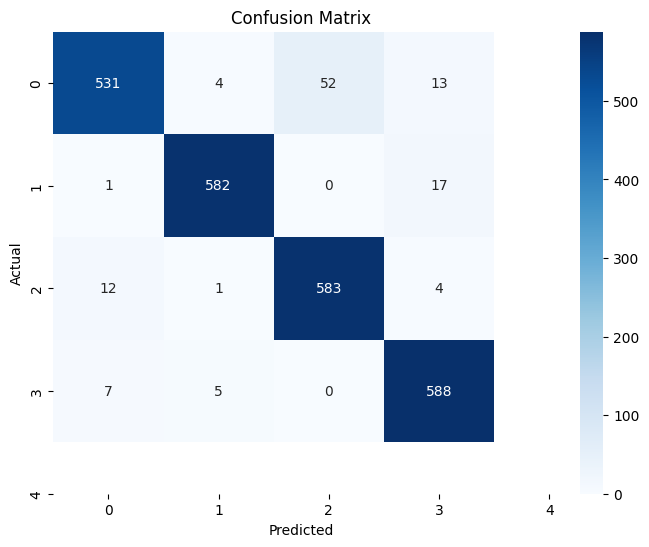

In [110]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions for the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [111]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(all_labels, all_preds))


Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       600
           1       0.98      0.97      0.98       600
           2       0.92      0.97      0.94       600
           3       0.95      0.98      0.96       600

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400

